# PARAMS

In [1]:
import numpy as np
import pandas as pd
import os
import xarray as xr
import seaborn as sns

from n0_config_params import *
from n0bis_config_analysis_functions import *
from n0quater_stats import *


/home/jules.granget/myenvs/py39c/lib64/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/jules.granget/myenvs/py39c/lib64/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# VS

In [2]:
z_score_VS = {}

for sujet in sujet_list:

    #### select data without aux chan
    prms = get_params(sujet, electrode_recording_type)
    data = load_data(sujet, 'FR_CV', electrode_recording_type)
    nasal_i = get_params(sujet, electrode_recording_type)['chan_list'].index('nasal')
    data = data[nasal_i,:]

    z_score_VS[sujet] = {'mean' : data.mean(), 'std' : data.std()}


In [3]:
electrode_recording_type = 'bipolaire'
nb_point_by_cycle = 1000

VS_data = {}

for sujet in sujet_list:

    respfeatures = load_respfeatures(sujet)['FR_CV'][0]
    chan_list, chan_list_ieeg = get_chanlist(sujet, electrode_recording_type)
    respi_i = chan_list.index('nasal')

    data = load_data(sujet, 'FR_CV', electrode_recording_type)[respi_i,:]

    if sujet == 'pat_03105_1551':
        data *= -1

    data = (data - z_score_VS[sujet]['mean']) / z_score_VS[sujet]['std']

    data_stretch = stretch_data(respfeatures, nb_point_by_cycle, data, srate)[0]

    VS_data[sujet] = data_stretch
        

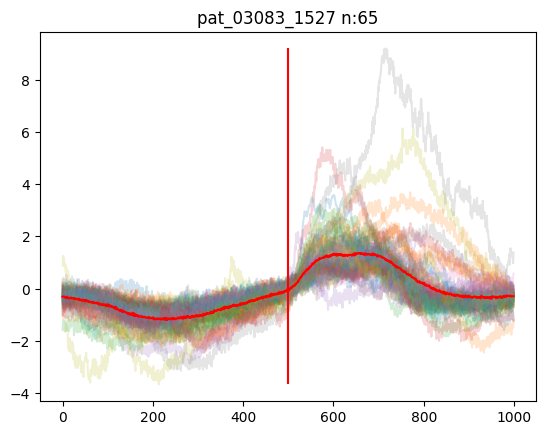

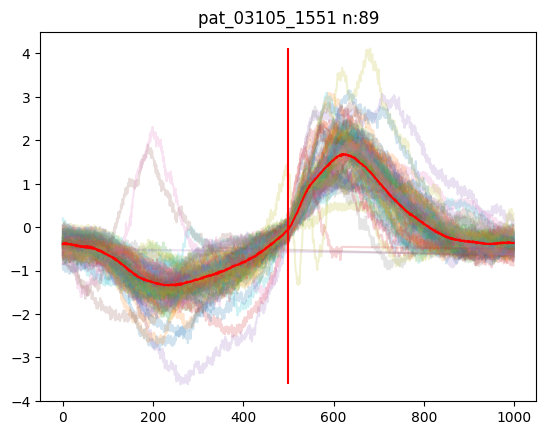

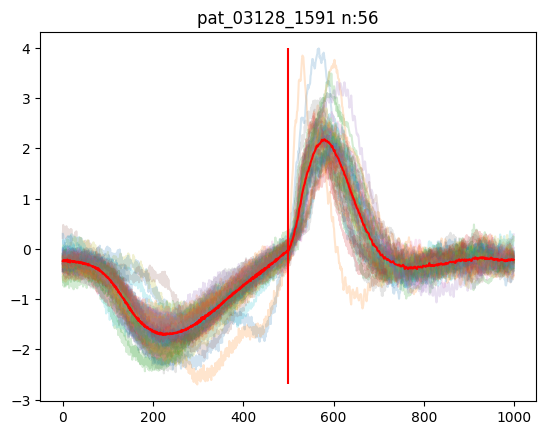

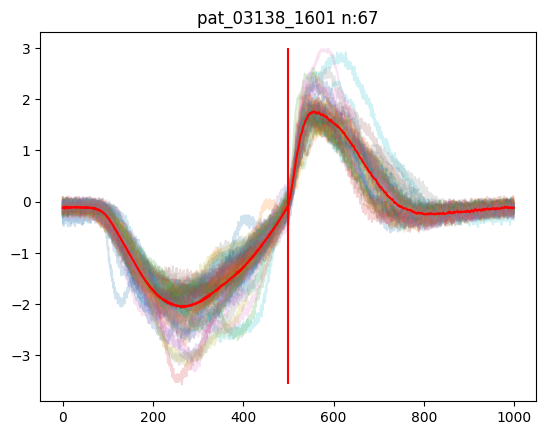

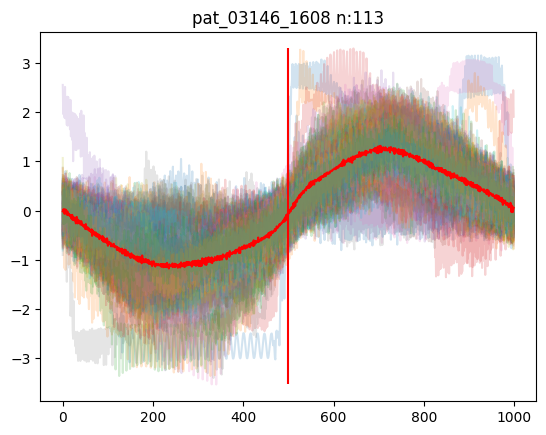

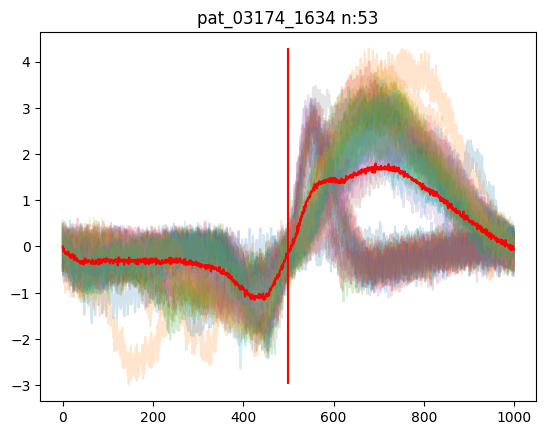

In [4]:
for sujet in sujet_list:

    data = VS_data[sujet]

    for ac_i in range(data.shape[0]):
        
        plt.plot(data[ac_i,:], alpha=0.2)

    plt.plot(data.mean(axis=0), color='r')
    plt.vlines([nb_point_by_cycle/2], ymin=data.min(), ymax=data.max(), color='r')
    plt.title(f"{sujet} n:{data.shape[0]}")

    plt.show()    

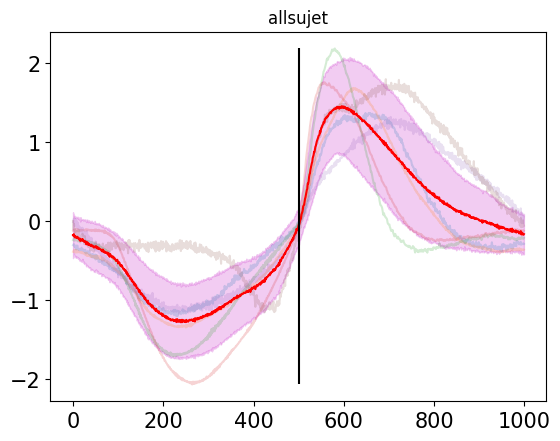

In [8]:
respi_mean_allsujet_SV = np.zeros((len(sujet_list), VS_data[sujet_list[0]].shape[-1]))
respi_mean_allsujet_SV_std = np.zeros((len(sujet_list), VS_data[sujet_list[0]].shape[-1]))

vals = np.array([])

for sujet_i, sujet in enumerate(sujet_list):

    data = VS_data[sujet]

    respi_mean_allsujet_SV[sujet_i, :] = data.mean(axis=0)
    respi_mean_allsujet_SV_std[sujet_i, :] = data.std(axis=0)

    plt.plot(data.mean(axis=0), alpha=0.2)

    vals = np.concatenate((vals, data.mean(axis=0)), axis=0)

plt.plot(range(VS_data[sujet_list[0]].shape[-1]), respi_mean_allsujet_SV.mean(axis=0), color='r')
plt.fill_between(range(VS_data[sujet_list[0]].shape[-1]), respi_mean_allsujet_SV.mean(axis=0)+respi_mean_allsujet_SV_std.mean(axis=0), respi_mean_allsujet_SV.mean(axis=0)-respi_mean_allsujet_SV_std.mean(axis=0), alpha=0.20, color='m')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.vlines([nb_point_by_cycle/2], ymin=vals.min(), ymax=vals.max(), color='k')
plt.title(f"allsujet")

plt.show()    

# AC

In [9]:
cond = 'AC'
stretch_point_TF_ac = int(np.abs(t_start_AC)*srate +  t_stop_AC*srate)
time_vec = np.linspace(t_start_AC, t_stop_AC, stretch_point_TF_ac)

respi_AC = {}

for sujet in sujet_list:

    #### select data without aux chan
    prms = get_params(sujet, electrode_recording_type)
    data = load_data(sujet, cond, electrode_recording_type)
    nasal_i = get_params(sujet, electrode_recording_type)['chan_list'].index('nasal')
    data = data[nasal_i,:]

    #### zscore
    data = (data - z_score_VS[sujet]['mean']) / z_score_VS[sujet]['std']

    if sujet == 'pat_03105_1551':
        data *= -1

    #### stretch or chunk
    ac_starts = get_ac_starts_uncleaned(sujet)

    srate = prms['srate']

    #### chunk
    data_stretch = np.zeros((len(ac_starts), int(stretch_point_TF_ac)))

    for start_i, start_time in enumerate(ac_starts):

        t_start = int(start_time + t_start_AC*srate)
        t_stop = int(start_time + t_stop_AC*srate)

        data_stretch[start_i, :] = data[t_start: t_stop]

    # xr_respi.loc[sujet,:] = data_stretch.shape
    respi_AC[sujet] = data_stretch

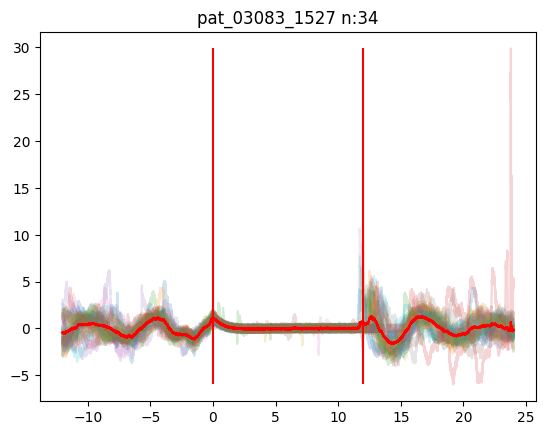

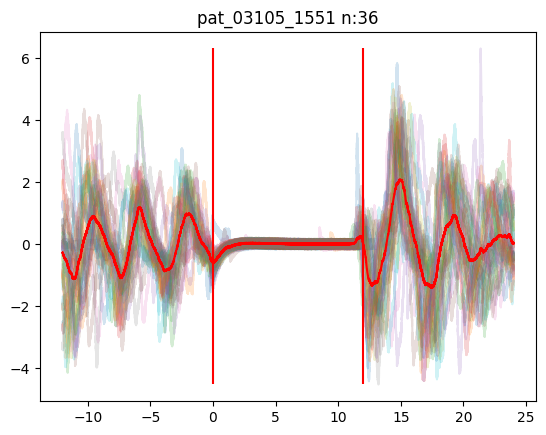

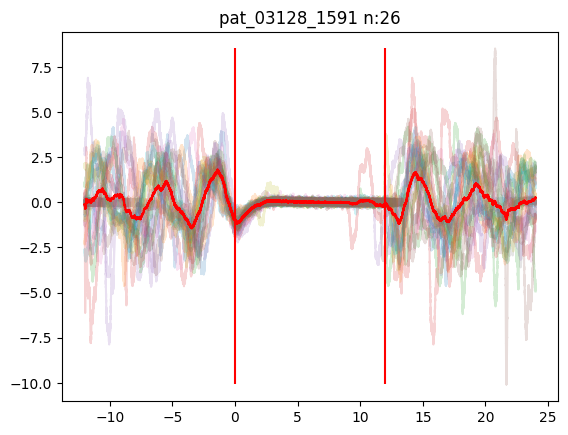

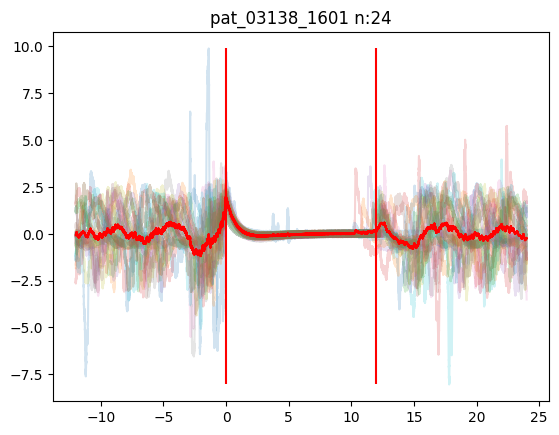

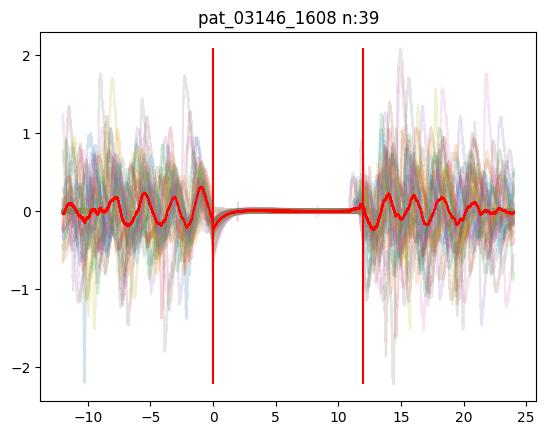

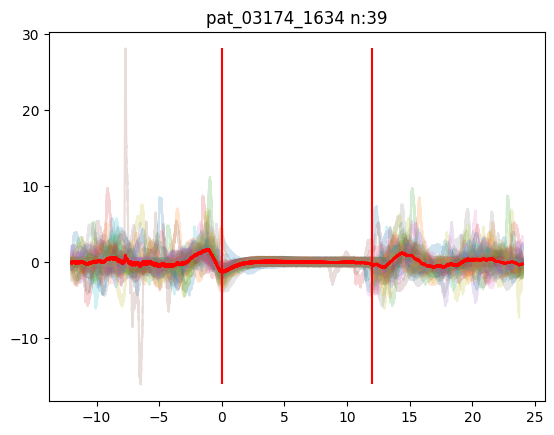

In [10]:
for sujet in sujet_list:

    data = respi_AC[sujet]

    for ac_i in range(data.shape[0]):
        
        plt.plot(time_vec, data[ac_i,:], alpha=0.2)

    plt.plot(time_vec, data.mean(axis=0), color='r')
    plt.vlines([0, 12], ymin=data.min(), ymax=data.max(), color='r')
    plt.title(f"{sujet} n:{data.shape[0]}")

    plt.show()    

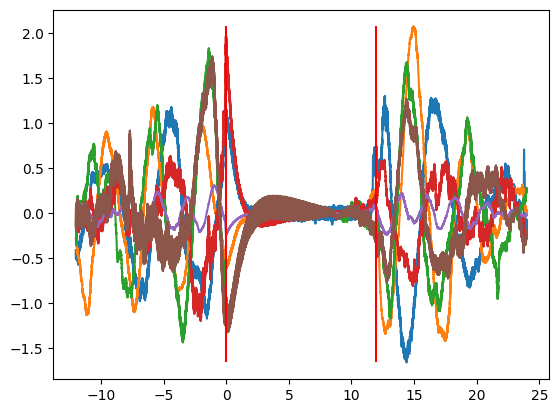

In [11]:
min, max = [], []

for sujet in sujet_list:

    data = respi_AC[sujet]

    plt.plot(time_vec, data.mean(axis=0))

    min.append(data.mean(axis=0).min())
    max.append(data.mean(axis=0).max())

min, max = np.array(min).min(), np.array(max).max()

plt.vlines([0, 12], ymin=min, ymax=max, color='r')

plt.show()    

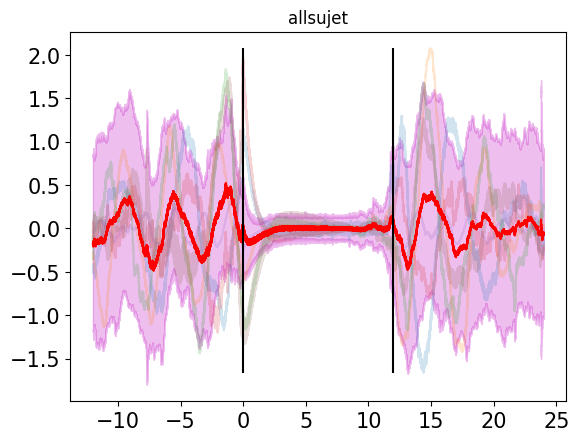

In [12]:
respi_mean_allsujet_AC = np.zeros((len(sujet_list), respi_AC[sujet_list[0]].shape[-1]))
respi_mean_allsujet_AC_std = np.zeros((len(sujet_list), respi_AC[sujet_list[0]].shape[-1]))

time_vec = np.linspace(t_start_AC, t_stop_AC, stretch_point_TF_ac)

vals = np.array([])

for sujet_i, sujet in enumerate(sujet_list):

    data = respi_AC[sujet]

    respi_mean_allsujet_AC[sujet_i, :] = data.mean(axis=0)
    respi_mean_allsujet_AC_std[sujet_i, :] = data.std(axis=0)

    vals = np.concatenate((vals, data.mean(axis=0)), axis=0)

    plt.plot(time_vec, data.mean(axis=0), alpha=0.2)

plt.plot(time_vec, respi_mean_allsujet_AC.mean(axis=0), color='r')
plt.fill_between(time_vec, respi_mean_allsujet_AC.mean(axis=0)+respi_mean_allsujet_AC_std.mean(axis=0), respi_mean_allsujet_AC.mean(axis=0)-respi_mean_allsujet_AC_std.mean(axis=0), alpha=0.25, color='m')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.vlines([0, 12], ymin=vals.min(), ymax=vals.max(), color='k')
plt.title(f"allsujet")

plt.show()    

# SNIFF

In [13]:
cond = 'SNIFF'
stretch_point_TF_sniff = int(np.abs(t_start_SNIFF)*srate +  t_stop_SNIFF*srate)
time_vec = np.linspace(t_start_SNIFF, t_stop_SNIFF, stretch_point_TF_sniff)

respi_SNIFF = {}

for sujet in sujet_list:

    #### select data without aux chan
    prms = get_params(sujet, electrode_recording_type)
    data = load_data(sujet, cond, electrode_recording_type)
    nasal_i = get_params(sujet, electrode_recording_type)['chan_list'].index('nasal')
    data = data[nasal_i,:]

    if sujet == 'pat_03105_1551':
        data *= -1

    #### zscore
    data = (data - z_score_VS[sujet]['mean']) / z_score_VS[sujet]['std']

    #### stretch or chunk
    sniff_starts = get_sniff_starts_uncleaned(sujet)

    srate = prms['srate']

    #### chunk
    data_stretch = np.zeros((len(sniff_starts), int(stretch_point_TF_sniff)))

    for start_i, start_time in enumerate(sniff_starts):

        t_start = int(start_time + t_start_SNIFF*srate)
        t_stop = int(start_time + t_stop_SNIFF*srate)

        data_stretch[start_i, :] = data[t_start: t_stop]

    respi_SNIFF[sujet] = data_stretch


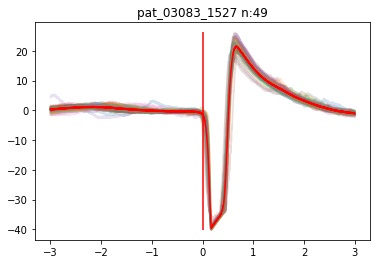

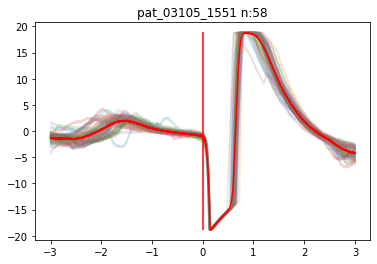

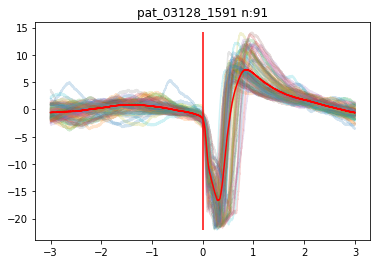

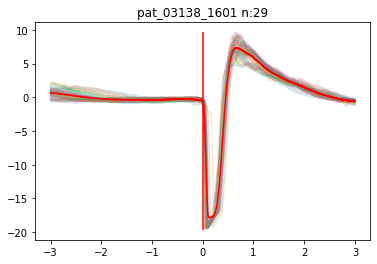

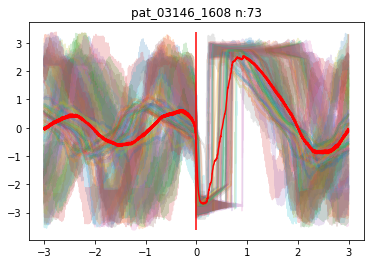

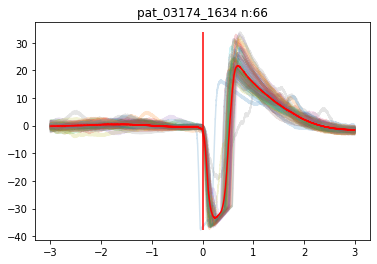

In [11]:
for sujet in sujet_list:

    data = respi_SNIFF[sujet]

    for ac_i in range(data.shape[0]):
        
        plt.plot(time_vec, data[ac_i,:], alpha=0.2)

    plt.plot(time_vec, data.mean(axis=0), color='r')
    plt.vlines([0], ymin=data.min(), ymax=data.max(), color='r')
    plt.title(f"{sujet} n:{data.shape[0]}")

    plt.show()   

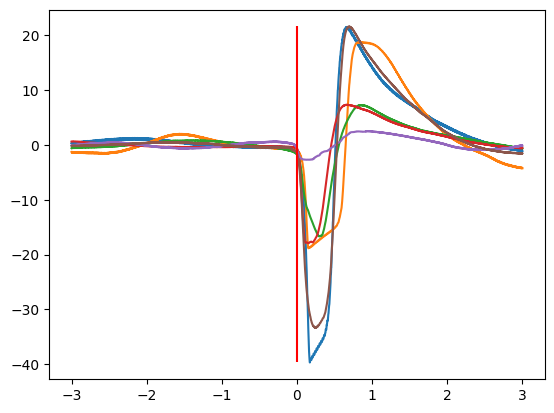

In [14]:
min, max = [], []

for sujet in sujet_list:

    data = respi_SNIFF[sujet]

    plt.plot(time_vec, data.mean(axis=0))

    min.append(data.mean(axis=0).min())
    max.append(data.mean(axis=0).max())

min, max = np.array(min).min(), np.array(max).max()

plt.vlines([0], ymin=min, ymax=max, color='r')

plt.show()    

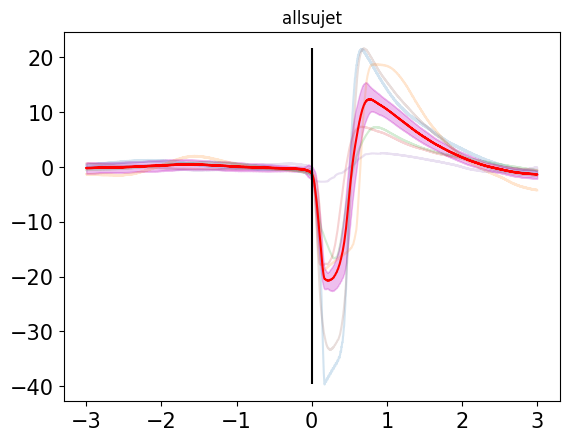

In [15]:
respi_mean_allsujet_SNIFF = np.zeros((len(sujet_list), respi_SNIFF[sujet_list[0]].shape[-1]))
respi_mean_allsujet_SNIFF_std = np.zeros((len(sujet_list), respi_SNIFF[sujet_list[0]].shape[-1]))

time_vec = np.linspace(t_start_SNIFF, t_stop_SNIFF, stretch_point_TF_sniff)

vals = np.array([])

for sujet_i, sujet in enumerate(sujet_list):

    data = respi_SNIFF[sujet]

    respi_mean_allsujet_SNIFF[sujet_i, :] = data.mean(axis=0)
    respi_mean_allsujet_SNIFF_std[sujet_i, :] = data.std(axis=0)

    vals = np.concatenate((vals, data.mean(axis=0)), axis=0)

    plt.plot(time_vec, data.mean(axis=0), alpha=0.2)

plt.plot(time_vec, respi_mean_allsujet_SNIFF.mean(axis=0), color='r')
plt.fill_between(time_vec, respi_mean_allsujet_SNIFF.mean(axis=0)+respi_mean_allsujet_SNIFF_std.mean(axis=0), respi_mean_allsujet_SNIFF.mean(axis=0)-respi_mean_allsujet_SNIFF_std.mean(axis=0), alpha=0.25, color='m')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.vlines([0], ymin=vals.min(), ymax=vals.max(), color='k')
plt.title(f"allsujet")

plt.show()    

In [14]:
data_df = {'sujet' : [], 'trial' : [], 'min' : []}
time_vec_mask = time_vec >= 0

for sujet in sujet_list:

    data = respi_SNIFF[sujet]

    for trial_i in range(data.shape[0]):

        data_df['sujet'].append(sujet)
        data_df['trial'].append(f"trial{trial_i}")
        data_df['min'].append(data[trial_i,time_vec_mask].min())

df_sniff = pd.DataFrame(data_df)
df_sniff


,sujet,trial,min
0,pat_03083_1527,trial0,-39.051474
1,pat_03083_1527,trial1,-38.172125
2,pat_03083_1527,trial2,-39.294801
3,pat_03083_1527,trial3,-38.076143
4,pat_03083_1527,trial4,-38.216545
...,...,...,...
361,pat_03174_1634,trial61,-36.052509
362,pat_03174_1634,trial62,-36.840305
363,pat_03174_1634,trial63,-36.011129
364,pat_03174_1634,trial64,-34.512052


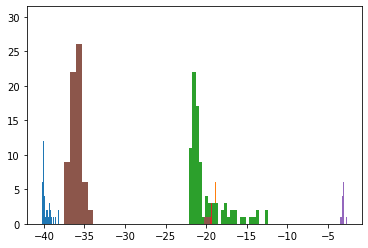

In [15]:
for sujet in sujet_list:
    plt.hist(df_sniff.query(f"sujet == '{sujet}'")['min'], bins=25)
plt.show()

In [16]:
df_sniff.query(f"sujet == 'pat_03146_1608'")

,sujet,trial,min
227,pat_03146_1608,trial0,-3.077311
228,pat_03146_1608,trial1,-3.212356
229,pat_03146_1608,trial2,-3.311605
230,pat_03146_1608,trial3,-3.347316
231,pat_03146_1608,trial4,-3.252498
...,...,...,...
295,pat_03146_1608,trial68,-2.756682
296,pat_03146_1608,trial69,-2.758600
297,pat_03146_1608,trial70,-2.756643
298,pat_03146_1608,trial71,-2.753928


# AL

In [6]:
os.chdir(os.path.join(path_results, 'allplot', 'allcond', 'lmm', 'regression_AL'))
df_AL = pd.read_excel('lm_allsujet_AL.xlsx') 
ROI_list_AL = df_AL['ROI'].unique()

In [7]:
df_AL

,Unnamed: 0,sujet,ROI,band,coef,pval,AL_time,AL_num
0,0,pat_03083_1527,amygdala,theta,0.01464,0.00000,63.002,AL_1
1,1,pat_03083_1527,amygdala,theta,0.01464,0.00000,76.002,AL_2
2,2,pat_03083_1527,amygdala,theta,0.01464,0.00000,87.002,AL_3
3,3,pat_03083_1527,amygdala,alpha,0.02314,0.00000,63.002,AL_1
4,4,pat_03083_1527,amygdala,alpha,0.02314,0.00000,76.002,AL_2
...,...,...,...,...,...,...,...,...
427,427,pat_03174_1634,temporal sup,beta,0.00218,0.00461,153.002,AL_2
428,428,pat_03174_1634,temporal sup,beta,0.00218,0.00461,162.002,AL_3
429,429,pat_03174_1634,temporal sup,gamma,0.00872,0.00000,95.002,AL_1
430,430,pat_03174_1634,temporal sup,gamma,0.00872,0.00000,153.002,AL_2


In [11]:
for ROI in ROI_list_AL:

    sns.lmplot(data=df_AL.query(f"ROI == '{ROI}' and band == 'theta'"), x="AL_time", y="coef", hue="AL_num")

    plt.title(f"{ROI} theta")
    plt.tight_layout()

    os.chdir(os.path.join(path_results, 'allplot', 'allcond', 'lmm', 'regression_AL'))
    plt.savefig(f'{ROI}_coeff_AL.png')

    plt.close('all')

# ALLCONDITIONS

In [17]:
dict = {'sujet' : [], 'VS' : [], 'SNIFF' : [], 'AC' : []}

for sujet in sujet_list:

    dict['sujet'].append(sujet)
    dict['VS'].append(VS_data[sujet].shape[0])
    dict['SNIFF'].append(respi_SNIFF[sujet].shape[0])
    dict['AC'].append(respi_AC[sujet].shape[0])

df_count_allcond = pd.DataFrame(dict)
df_count_allcond

,sujet,VS,SNIFF,AC
0,pat_03083_1527,65,49,34
1,pat_03105_1551,89,58,36
2,pat_03128_1591,56,91,26
3,pat_03138_1601,67,29,24
4,pat_03146_1608,113,73,39
5,pat_03174_1634,53,66,39
